# Individual Values Collection survey v1

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [ ]:
# Read excel file
%pip install openpyxl
df = pd.read_excel('Individual values collection survey v1 (respuestas).xlsx')
df

Note: you may need to restart the kernel to use updated packages.


Index(['Marca temporal',
       'If you are from Glasshome team, please write your name',
       'What is your age?', 'What is your nationality?',
       'What is your gender?',
       'What is your family status (single, in a relationship, married, with kids, other)?',
       'Living together\n“Imagine you’re living in a shared community or co-housing project. What matters most to you in how people live together?”',
       'Decision-making and rules\n“When the group needs to make decisions or set rules, what do you think is the best way to do that?”',
       'Personal contribution\n“What would you most like to contribute or receive in a community like this?”',
       'What do you think about this survey?'],
      dtype='object')

In [29]:
df

,Marca temporal,"If you are from Glasshome team, please write your name",What is your age?,What is your nationality?,What is your gender?,"What is your family status (single, in a relationship, married, with kids, other)?",Living together\n“Imagine you’re living in a shared community or co-housing project. What matters most to you in how people live together?”,"Decision-making and rules\n“When the group needs to make decisions or set rules, what do you think is the best way to do that?”",Personal contribution\n“What would you most like to contribute or receive in a community like this?”,What do you think about this survey?
0,2025-11-14 15:11:36.495,Lucas,33,german,male,-,Private spaces and a well designed architectur...,I think the best decisions are the ones that y...,"Leading workshops, connecting community member...",This question should be on the same page so I ...
1,2025-11-14 16:04:17.481,Aaryan,27,Indian,Male,relationship,Mutual respect and understanding. Sense of bel...,The group should make sure decisions are inclu...,Community building. Every person has their nic...,NaN
2,2025-11-14 20:50:57.674,Rebecca,31,Sweden,Female,"Relationship, one kid",That there is a sense of togetherness- that we...,I think there needs to be some social structur...,"I would like to arrange events, sharing and es...",Think it’s good. Like that it is short :) woul...
3,2025-11-19 14:02:42.492,Alejandra,28,Spanish,Female,Relationship,What matters to me is to share time and activi...,I think that the best way is that everyone has...,I would want to contribute by giving company a...,NaN
4,2025-11-19 15:52:10.061,Gilles,30,German,Male,IaR,Living together in respect and harmony is one ...,Discuss the case together and then hold a vote...,Be open and sharing to inspire others and at t...,The questions are well thought out. Makes one ...
5,2025-11-20 08:49:12.900,NaN,28,Spanish,Male,In a relationship,"Be somewhat aligned on the values, understan e...",Having an honest conversation on which everyon...,"Everyday conversation, time to time activities...",Easy to understand questions but really open t...
6,2025-11-21 08:37:25.000,Zhuojing,27,Chinese,Female,In a relationship,Inclusivity matters most that everyone can be ...,Divide into small groups to discuss and then d...,Concern for each other. Love. Skills and talen...,"The survey is simple to fill, but also thought..."


In [3]:
# Model
from transformers import AutoTokenizer, AutoModel
import torch

model_name = "lorenzozan/ME2-BERT"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

In [9]:
# Prepare inputs and run model
texts_living_together = df['Living together\n“Imagine you’re living in a shared community or co-housing project. What matters most to you in how people live together?”'].tolist()
inputs = tokenizer(texts_living_together, padding="max_length", truncation=True, return_tensors="pt")
model.eval()  # optional but best practice
with torch.no_grad():
    outputs_living_together = model(**inputs, return_dict=True)

# Prepare inputs and run model
texts_decision_making = df['Decision-making and rules\n“When the group needs to make decisions or set rules, what do you think is the best way to do that?”'].tolist()
inputs = tokenizer(texts_decision_making, padding="max_length", truncation=True, return_tensors="pt")
model.eval()  # optional but best practice
with torch.no_grad():
    outputs_decision_making = model(**inputs, return_dict=True)

# Prepare inputs and run model
texts_personal_contribution = df['Personal contribution\n“What would you most like to contribute or receive in a community like this?”'].tolist()
inputs = tokenizer(texts_personal_contribution, padding="max_length", truncation=True, return_tensors="pt")
model.eval()  # optional but best practice
with torch.no_grad():
    outputs_personal_contribution = model(**inputs, return_dict=True)

In [10]:
# Transform outputs to a matrix of shape (num_users, embedding_dim)
# Choose column order explicitly
cols = ['CH', 'FC', 'LB', 'AS', 'PD']

matrix_living_together = np.array([[d.get(c, 0.0) for c in cols] for d in outputs_living_together])
print("numpy shape:", matrix_living_together.shape)
scores_living_together = matrix_living_together.copy()  # Use this scores matrix for clustering

matrix_decision_making = np.array([[d.get(c, 0.0) for c in cols] for d in outputs_decision_making])
print("numpy shape:", matrix_decision_making.shape)
scores_decision_making = matrix_decision_making.copy()  # Use this scores matrix for clustering

matrix_personal_contribution = np.array([[d.get(c, 0.0) for c in cols] for d in outputs_personal_contribution])
print("numpy shape:", matrix_personal_contribution.shape)
scores_personal_contribution = matrix_personal_contribution.copy()  # Use this scores matrix for clustering

numpy shape: (7, 5)
numpy shape: (7, 5)
numpy shape: (7, 5)


### Cosine similarity

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity
cosine_sim_living_together = cosine_similarity(scores_living_together)
cosine_sim_decision_making = cosine_similarity(scores_decision_making)
cosine_sim_personal_contribution = cosine_similarity(scores_personal_contribution)

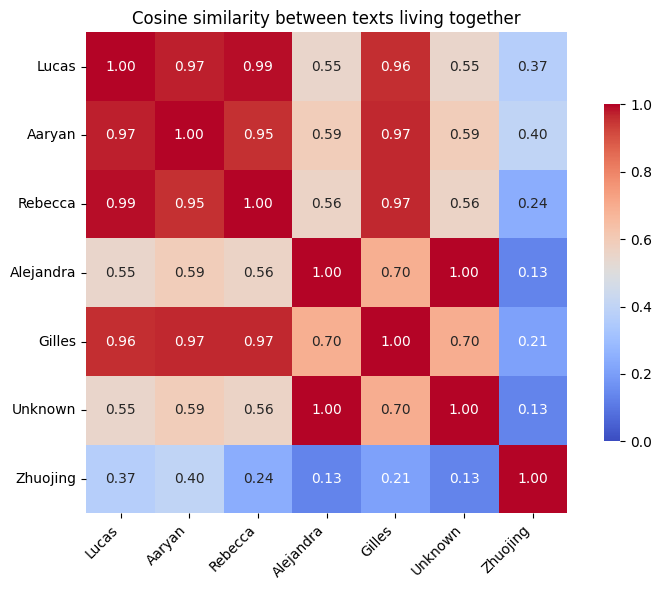

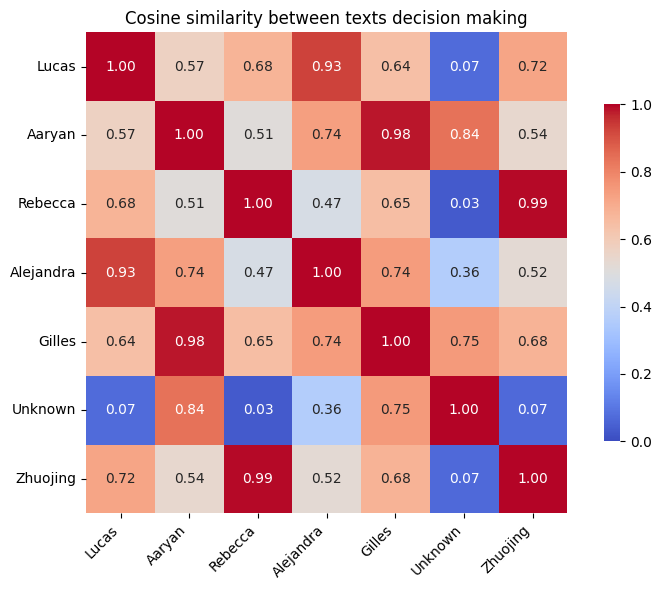

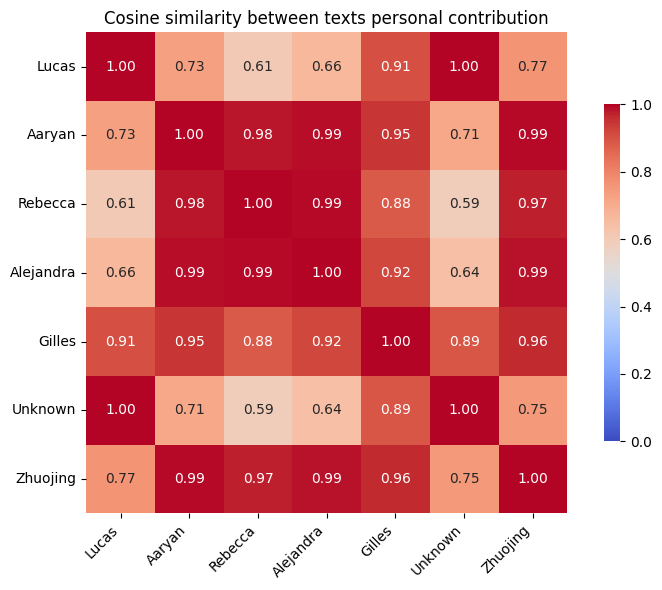

In [24]:
# Friendly row/col labels
cosine_sim = cosine_sim_living_together  # Change to desired similarity matrix

n = cosine_sim.shape[0]
labels = [f'User {i+1}' for i in range(n)]
labels = ["Lucas", "Aaryan", "Rebecca", "Alejandra", "Gilles", "Unknown", "Zhuojing"]

# Simple heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cosine_sim, xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f",
            cmap="coolwarm", vmin=0, vmax=1, square=True, cbar_kws={"shrink":0.7})
plt.title("Cosine similarity between texts living together")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Simple heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cosine_sim_decision_making, xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f",
            cmap="coolwarm", vmin=0, vmax=1, square=True, cbar_kws={"shrink":0.7})
plt.title("Cosine similarity between texts decision making")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Simple heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cosine_sim_personal_contribution, xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f",
            cmap="coolwarm", vmin=0, vmax=1, square=True, cbar_kws={"shrink":0.7})
plt.title("Cosine similarity between texts personal contribution")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

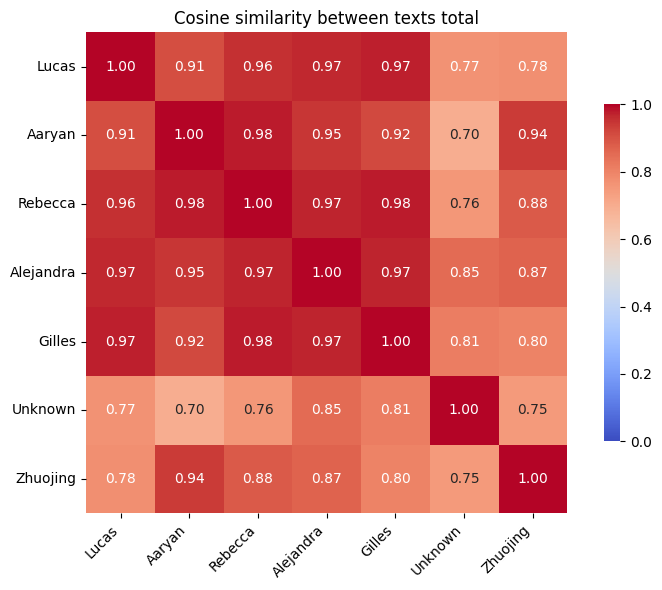

In [28]:
# Now all texts together
# Make the average of the vectors by row

scores_total = (scores_living_together + scores_decision_making + scores_personal_contribution) / 3

cosine_sim_total = cosine_similarity(scores_total)

# Simple heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cosine_sim_total, xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f",
            cmap="coolwarm", vmin=0, vmax=1, square=True, cbar_kws={"shrink":0.7})
plt.title("Cosine similarity between texts total")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()